## Import libraries

In [11]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt


## Load images and labels

In [92]:
# Function to load images from a folder and convert them to a tensor
def load_images_and_labels(images_path, labels_path):
    df_labels = pd.read_csv(labels_path)
    images_paths = os.listdir(images_path)
    images = []
    labels = []
    for filename in tqdm(images_paths, desc = "Reading images"):
        if filename.endswith(".png"):
            img_path = os.path.join(images_path, filename)
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img) / 255
            label = df_labels[df_labels['Image'] == filename]['Class'].values[0]
            images.append(img_array)
            labels.append(label)
    labels_tensor = torch.Tensor(labels)
    images_tensor = torch.Tensor(images)
    return images_tensor, labels_tensor


In [93]:
# Specify the paths
train_images_folder_path = "train_images"
labels_path = "train.csv"

# Load images and labels into tensors
train_images, train_labels = load_images_and_labels(train_images_folder_path, labels_path)

# Print the shapes of the resulting tensors
print("Images Tensor Shape:", train_images.shape)
print("Labels Tensor Shape:", train_labels.shape)


Reading images: 100%|██████████| 13000/13000 [00:48<00:00, 268.90it/s]


Images Tensor Shape: torch.Size([13000, 64, 64, 3])
Labels Tensor Shape: torch.Size([13000])


## EDA

In [ ]:
unique_labels, counts = np.unique(train_labels, return_counts=True)

# Step 2: Print the count of images in each class
for label, count in zip(unique_labels, counts):
    print(f"Class {label}: {count} images")

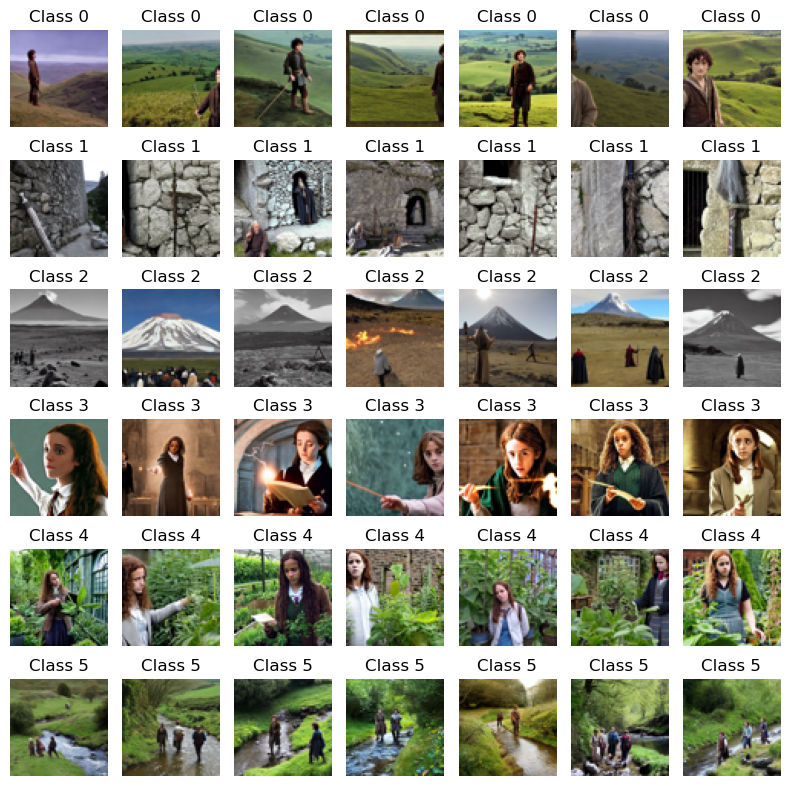

In [94]:
num_examples_to_display = 7
# Create subplots
fig, axes = plt.subplots(6, 7, figsize=(8, 8))

# Flatten the axes to simplify indexing
axes = axes.flatten()
i = 0

for label in [0, 1, 2, 3, 4, 5]:
    indices_in_class = np.where(train_labels == label)[0][:num_examples_to_display]
    for index in indices_in_class:
        example_image = train_images[index, :, :, :].numpy() 
        # print(f"   Example {index}: {example_image.shape}")
        # print(f"   Min value: {example_image.min()}")
        # print(f"   Max value: {example_image.max()}")
        axes[i].imshow(example_image)
        axes[i].axis('off')  # Turn off axis labels
        axes[i].title.set_text(f"Class {label}")
        i += 1
# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()

In [35]:
for label in [0, 1, 2, 3, 4, 5]:
    indices_in_class = np.where(train_labels == label)[0][:num_examples_to_display]
    print(f"Class {label}: {indices_in_class}")


Class 0: [ 27  66  71 111 125 215 343]
Class 1: [ 15 130 150 152 154 243 269]
Class 2: [ 17  55  85  86 104 122 127]
Class 3: [ 56 159 240 253 348 364 661]
Class 4: [ 57 279 319 322 497 513 664]
Class 5: [ 87 112 330 336 519 831 893]


## Models

In [100]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
def AlexNet_modified():
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (11, 11), activation='relu', strides=(2, 2)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(layers.Conv2D(128, (5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten before fully connected layersa
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(4608, activation='relu'))
    # add dropout to prevent overfitting
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(100, activation='softmax'))  # Output size is the number of classes

    return model

def GoogLeNet_modified():
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (7, 7), activation='relu', strides=(2, 2)))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))
    model.add(layers.Conv2D(64, (5, 5), activation='relu', strides=(1, 1), padding='same'))
    model.add(layers.MaxPooling2D((3, 3), strides=(2, 2)))

    # Flatten before fully connected layersa
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(2304, activation='relu'))
    # add dropout to prevent overfitting
    # model.add(layers.Dropout(0.5))
    model.add(layers.Dense(100, activation='softmax'))  # Output size is the number of classes

    return model


# Instantiate the model
model = AlexNet_modified()

# Call the model on some input data to build it
dummy_input = tf.ones((1,) + (64, 64, 3))
model(dummy_input)

# Now, you can print the model summary
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (1, 27, 27, 64)           23296     
                                                                 
 max_pooling2d_26 (MaxPooli  (1, 13, 13, 64)           0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (1, 13, 13, 128)          204928    
                                                                 
 max_pooling2d_27 (MaxPooli  (1, 6, 6, 128)            0         
 ng2D)                                                           
                                                                 
 flatten_12 (Flatten)        (1, 4608)                 0         
                                                                 
 dense_25 (Dense)            (1, 4608)               

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Assuming you have images_tensor and labels_tensor from previous steps

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=42)

# Convert NumPy arrays to TensorFlow tensors
X_train_tensor = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test_tensor = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test, dtype=tf.float32)


In [101]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Assuming labels are integers
              metrics=['accuracy'])

In [102]:
# Define loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model[0].parameters(), lr=0.001)

model.fit(X_train_tensor, y_train_tensor, epochs=25, validation_data=(X_test_tensor, y_test_tensor))



Epoch 1/25
325/325 [==============================] - 120s 363ms/step - loss: 4.6086 - accuracy: 0.0080 - val_loss: 4.6063 - val_accuracy: 0.0062
Epoch 2/25
325/325 [==============================] - 119s 366ms/step - loss: 4.6057 - accuracy: 0.0100 - val_loss: 4.6071 - val_accuracy: 0.0062
Epoch 3/25
325/325 [==============================] - 120s 370ms/step - loss: 4.6096 - accuracy: 0.0094 - val_loss: 4.6079 - val_accuracy: 0.0062
Epoch 4/25
325/325 [==============================] - 120s 370ms/step - loss: 4.6054 - accuracy: 0.0091 - val_loss: 4.6086 - val_accuracy: 0.0062
Epoch 5/25
325/325 [==============================] - 116s 358ms/step - loss: 4.6053 - accuracy: 0.0098 - val_loss: 4.6092 - val_accuracy: 0.0062
Epoch 6/25
325/325 [==============================] - 117s 361ms/step - loss: 4.6053 - accuracy: 0.0106 - val_loss: 4.6097 - val_accuracy: 0.0065
Epoch 7/25
325/325 [==============================] - 117s 359ms/step - loss: 4.6053 - accuracy: 0.0107 - val_loss: 4.6101 -

KeyboardInterrupt: 